In [2]:
# MobileNetV2를 전이학습하여 후 강아지, 고양이 분류 모델 생성
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds    # 공개 데이터셋


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
train 원본(전체) 개수 :  23262
raw_train 개수 :  18609
raw_validation 개수 :  2326
raw_test 개수 :  2326
원본 1장 :  (262, 350, 3) 1
dog


2025-09-24 16:42:32.911673: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-09-24 16:42:32.911695: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-09-24 16:42:32.911698: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-09-24 16:42:32.911712: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-24 16:42:32.911723: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-09-24 16:42:33.009682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


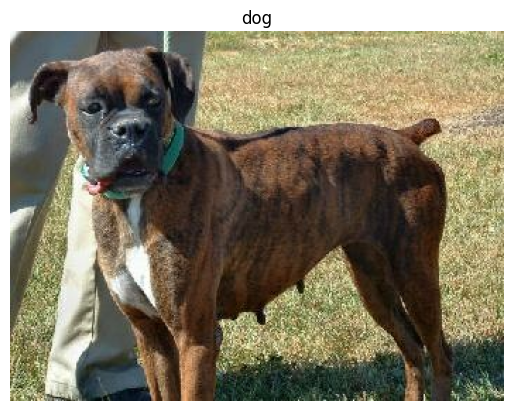

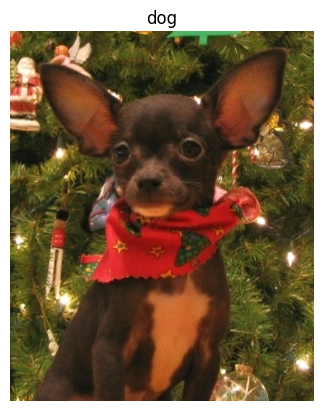

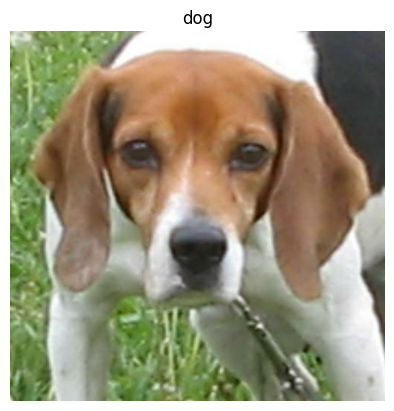

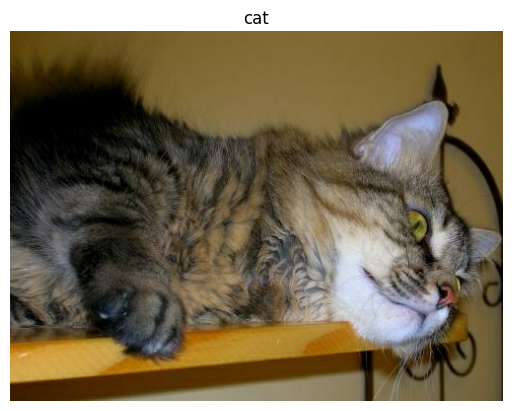

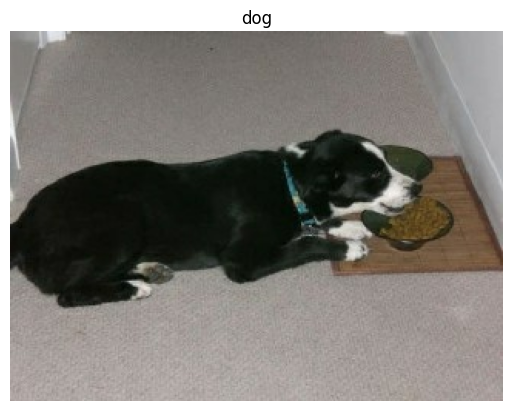

2025-09-24 16:42:33.409215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
tfds.disable_progress_bar()    # stop showing download/loading progress bars, for cleaner logs

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,     # 관련 정보 보기
    as_supervised=True,     # True : tuple type으로 반환 , False : dict type으로 반환
)

print(raw_train)
print(raw_validation)
print(raw_test)
# print(metadata)

total = metadata.splits['train'].num_examples
print("train 원본(전체) 개수 : ", total)
print("raw_train 개수 : ", int(total * 0.8))
print("raw_validation 개수 : ", int(total * 0.1))
print("raw_test 개수 : ", int(total * 0.1))

# 샘플 크기 확인
for image, label in raw_train.take(1):
    print('원본 1장 : ', image.shape, label.numpy()) # (262, 350, 3) 1
    
# 레이블 확인
get_label_name = metadata.features['label'].int2str
print(get_label_name(1))    # dog

# 이미지 한 장 시각화
for image, label in raw_train.take(5):
    plt.figure()
    plt.imshow(image)
    plt.title(f"{get_label_name(label)}")
    plt.axis('off')   
    plt.show()
    plt.close()

## 이미지 사이즈가 제각각이어서 손 봐줘서 MobileNetV2에 넣어줘야된다.

In [4]:
# 전처리
IMG_SIZE = 160     # MobileNetV2가 원하는 사이즈
def format_ex(image, label):
    image = tf.cast(image, tf.float32)   # int8 -> float32
    image = (image / 127.5) - 1.0     # -1 ~ 1 사이 스케일링
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

# AUTOTUNE : GPU 코어 개수/리소스 상황에 맞게 자동으로 최적화
# GPU idle time을 최소화
train = raw_train.map(format_ex, num_parallel_calls=tf.data.AUTOTUNE)
validation = raw_validation.map(format_ex, num_parallel_calls=tf.data.AUTOTUNE)
test = raw_test.map(format_ex, num_parallel_calls=tf.data.AUTOTUNE)

# 출력 검증
for img, label in train.take(1):
    print('전처리 결과(type) : ', img.dtype)
    print('전처리 결과(shape) : ', img.shape)
    print('Min/Max : ', float(tf.reduce_min(img)), float(tf.reduce_max(img)))    # 예상 결과 -1, 1(차원 축소)


# Batch 파이프라인 작성 (학습용/검증용)
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
# train만 shuffle
# 1000개의 샘플을 메모리에 가져와 무작위로 섞음 -> 그 다음 데이터 버퍼에 읽어서 또 섞음
train_batches = (train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))
validation_batches = (validation.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))
test_batches = (test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))

for image_single, label_single in raw_train.take(2):
    print('원본 단일 이미지 shape : ', image_single.numpy().shape)
    print('레이블 : ', label_single.numpy())
    

전처리 결과(type) :  <dtype: 'float32'>
전처리 결과(shape) :  (160, 160, 3)
Min/Max :  -1.0 1.0
원본 단일 이미지 shape :  (262, 350, 3)
레이블 :  1
원본 단일 이미지 shape :  (409, 336, 3)
레이블 :  1


2025-09-24 16:42:33.552749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-24 16:42:33.591399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# 베이스 모델
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet')

# base_model.summary()

# 전처리/Batch된 텐서를 통과시켜 특징
images_batch, labels_batch = next(iter(train_batches))
feature_batch = base_model(images_batch)
print('입력 배치 shape : ', images_batch.shape)
print('특징맵 배치 shape : ', feature_batch.shape)

# GAP : GAP의 목적은 feature를 1차원 벡터로 만들기 위함(Flatten과 반대로 파라미터 수를 줄일 수 있다.)
global_avg = tf.keras.layers.GlobalAveragePooling2D()(feature_batch)
print('GAP 이후 shape : ', global_avg.shape)

# 모델 정의
# Sequential api 방식
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Input(shape=IMG_SHAPE),
#     base_model,   # 특징추출기(Convolution) 동결 상태(갱신을 안하고 사용하겠다)
#     tf.keras.layers.GlobalAveragePooling2D(),    # GAP
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# Functional api 방식
inputs = tf.keras.layers.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs, outputs)

# 학습
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history1 = model.fit(train_batches, epochs=5, batch_size=32, validation_data=validation_batches, verbose=1)

# 평가
print(f"test 평가 결과 : {model.evaluate(test_batches, verbose=0)}")

In [ ]:
# 시각화
plt.figure(figsize=(12,5))
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epoch = range(1, len(acc) + 1)

plt.subplot(1,2,1)
plt.plot(epoch, acc, label='acc')
plt.plot(epoch, val_acc, label='val_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(epoch, loss, label='loss')
plt.plot(epoch, val_loss, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')

In [ ]:
# Callbacks
callback = [
    tf.keras.callbacks.ModelCheckPoint('finetune_best.keras',monitor='val_loss', ),
    tf.keras.callbacks.EarlyStop(monitor='val_loss', patience=3),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

In [ ]:
# Fine Tuning 모델 호출
model_load = tf.keras.models.load_model('finetune_best.keras')
# model.summary()

history2 = model_load.fit(train_batches, epochs=5, batch_size=32, validation_data=validation_batches, verbose=1, callbacks=callback)

# 평가
print(f"test 평가 결과 : {model.evaluate(test_batches, verbose=0)}")

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 243s 394ms/step - accuracy: 0.9804 - loss: 0.0524 - val_accuracy: 0.9807 - val_loss: 0.0548
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 240s 412ms/step - accuracy: 0.9859 - loss: 0.0392 - val_accuracy: 0.9802 - val_loss: 0.0549
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 245s 420ms/step - accuracy: 0.9902 - loss: 0.0286 - val_accuracy: 0.9802 - val_loss: 0.0573
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 267s 458ms/step - accuracy: 0.9929 - loss: 0.0227 - val_accuracy: 0.9785 - val_loss: 0.0635
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 257s 440ms/step - accuracy: 0.9919 - loss: 0.0222 - val_accuracy: 0.9794 - val_loss: 0.0600
test 평가 결과 : [0.10551048815250397, 0.9621667861938477]


In [ ]:
EPOCHS_TRANSFER = 100

In [ ]:
# 전이학습 vs 미세조정 학습 곡선 결합한 시각화
def concat_hist_func(h1, h2):
    keys = h1.history.keys()
    out = {}
    for k in keys:
        out[k] = h1.history[k] + h2.history[k]
    return out

hist_all = concat_hist_func(history1, history2)
acc = hist_all['accuracy']
val_acc = hist_all['val_accuracy']
loss = hist_all['loss']
val_loss = hist_all['val_loss']

epochs = range(1, len(acc) + 1)
split_epoch = EPOCHS_TRANSFER    # 전이학습과 미세조정 경계선 위치

plt.figure(figsize=(12,5))
# Accuracy 정확도
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'o', label='train acc')
plt.plot(epochs, val_acc, 's', label='val acc')
for i, v in enumerate(acc):
    plt.text(epochs[i], v, f"{v * 100:.1f}%", ha='center', va='bottom', fontsize=8)

for i, v in enumerate(val_acc):
    plt.text(epochs[i], v, f"{v * 100:.1f}%", ha='center', va='bottom', fontsize=8)
    
plt.axvline(split_epoch, linestyle='--', alpha=0.6, label='Fine-tuning go')
plt.title('Accuracy (Transfer -> Fine Tune)')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(loc='best')

# Loss 손실
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'o', label='train loss')
plt.plot(epochs, val_loss, 's', label='val loss')
for i, v in enumerate(loss):
    plt.text(epochs[i], v, f"{v * 100:.1f}%", ha='center', va='bottom', fontsize=8)

for i, v in enumerate(val_acc):
    plt.text(epochs[i], v, f"{v * 100:.1f}%", ha='center', va='bottom', fontsize=8)
    
plt.axvline(split_epoch, linestyle='--', alpha=0.6, label='Fine-tuning go')
plt.title('Accuracy (Transfer -> Fine Tune)')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()